<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Deep_Convolutional_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 30th Sep, 2023
# Ref: https://www.tensorflow.org/tutorials/generative/dcgan
# https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/

## Install software
Needed to create gifs

In [13]:
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f63w5fhw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-f63w5fhw
  Resolved https://github.com/tensorflow/docs to commit c40e0e812c9552e1f9c9afc6e9af4cd41e488c9c
  Preparing metadata (setup.py) ... done


## How GAN's ate trained?

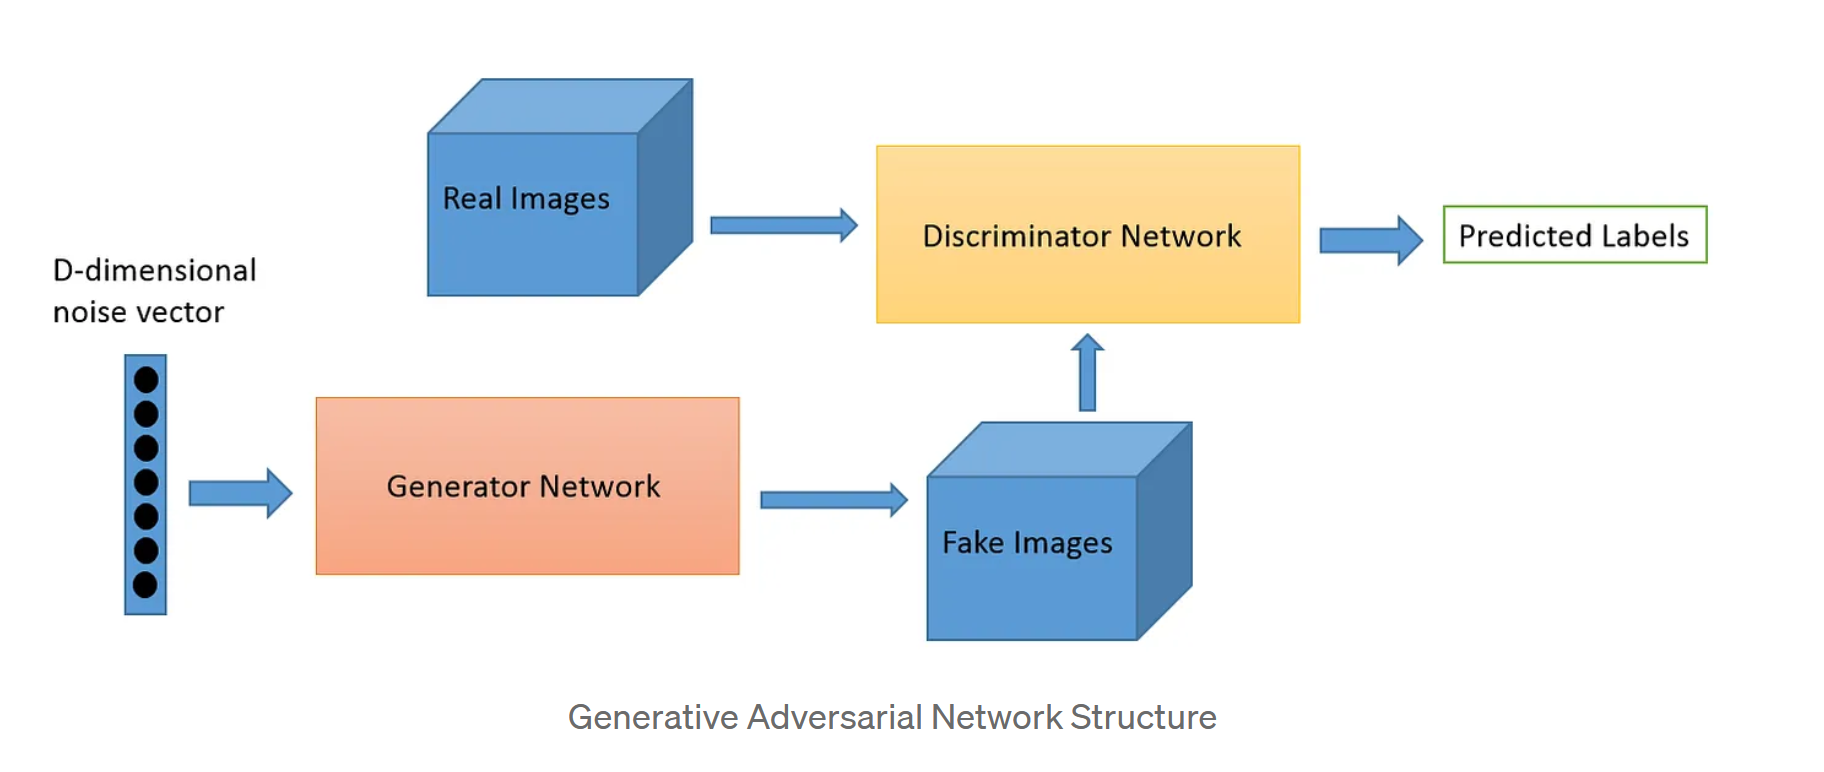

>In the first phase we train the discriminator, A batch of real images is sampled from the training set and is completed with an equal number of fake images produced by the generator. The labels are set to 0 for fake images and 1 for real images and the discriminator is trained on this labeled batch for one step, using the binary cross-entropy loss. Importantly, backpropogation omly optimizes the weights of the discriminator during this pahse.  
>In the second phase, we train the generator. We first use it to produce another batch of fake images, and once again the discriminator is used to tell whether the images are fake or real. This time we do not add the real images in the batch, and all the labels are set to 1 (real): in other words we want the generator to produce images tha the discriminator will (wrongly) believe to be real! Crucially, the weights of the discriminator are frozen during this step, so backpropogation only affects the weights of the generator.

The generator never actually sees any real images, yet it gradually learns to produce convincing fake images. All it gets is the gradient flowing back through the discriminator. Fortunately, the better the dicriminator gets, the more information abouth the real images is contained in these secondhand gradients, so the generator can make significant progress.

### How Convolutional layer works

Feature map size calculation:  
Output feature map size = 1 + (Input Size - Filter size + 2 * Padding) /

In [ ]:
display.Image(url='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/12/2_strided_conv_do_not_smush.gif?size=395x381&lossy=2&strip=1&webp=1')


### How Convolutional Transpose layer works  
Also called Deconvolution
See [here](https://blog.paperspace.com/transpose-convolution/)

Image size calculation:  

>In the equation for convolutioanl output size, replace output by input and vice versa. Then, rearrange variables: <br>
>input size = 1 + (Output size - Filter size + 2 * Padding) / Stride
To get:  
>Transpose Convolution Output Size = (Input Size - 1) * Strides + Filter Size - 2 * Padding + Ouput Padding

In [ ]:
display.Image(url='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/12/3_fractional_strided_conv_do_not_smush.gif?size=395x449&lossy=2&strip=1&webp=1')

In [ ]:
# 1.0 Call libraries:


import numpy
import tensorflow as tf
from tensorflow.keras import layers

# 1.0.1 Image plotting related
import imageio
import matplotlib.pyplot as plt
import PIL

# 1.0.2 File system related
import os
import glob

# 1.0.3 Others
import time
from IPython import display

In [ ]:
# 1.1 Display multiple outputs from a cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Load data
We will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.


In [ ]:
# 2.0 Forget test images:

(train_images, train_labels) , (_,_) = tf.keras.datasets.mnist.load_data()
train_images.shape  # (60000, 28, 28)

11490434/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [14]:
# 2.1 Reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')

# 2.2 We will use tanh as output activation function:
train_images = (train_images - 127.5)/127.5

# 2.3 Recheck
train_images.min() ; train_images.max()

-1.0078431

-0.99215686

### Dataset transformation
Transform the dataset to tensorflow dataset format. BUFFER_SIZE is important for shuffling the data. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, set the buffer size equal to the full size of the dataset.   
As tensorflow is meant for vary large datasets, spread over many machines, it is not practical to shuffle the whole dataset again and again at the begiining of each epoch.

In [15]:
# 3.1
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# 3.2 Shuffle the dataset and also batch it:

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model creation

### Generator model

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

See [here](https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/)<br>
And [here](https://blog.paperspace.com/transpose-convolution/)

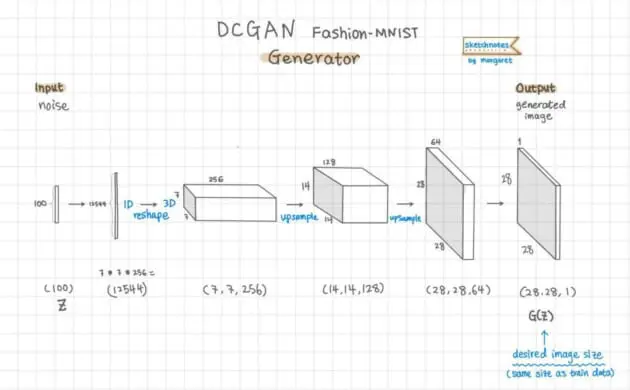

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Out generator receives 1-D random inputs
    # Hence first hidden layer is a Dense vector:
    # Call this 1-D as latent space:

    # Size of 7 * 7 * 256 is dictated by out final output 28*28*1
    # See above diagram
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Use the (as yet untrained) generator to create an image.

In [17]:
# Create the generator model now:

generator = make_generator_model()

In [18]:
# Get some inputs
noise = tf.random.normal([1, 100])
noise.shape
noise

TensorShape([1, 100])

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.6574354 , -0.28134817,  0.5069135 , -0.9335385 , -1.553872  ,
         0.38877937,  1.7883092 ,  1.6140494 , -0.4196798 , -0.7348074 ,
         0.48067054, -1.2736322 , -0.51391864,  0.2893275 ,  0.56961554,
         0.8397361 ,  0.56766105,  0.70897394,  1.3180737 ,  1.2636064 ,
         0.7197546 ,  0.9472892 , -1.1174113 , -0.60303825, -0.12368614,
         1.0295724 ,  0.56601083, -2.161328  ,  0.23870896, -0.79431176,
         1.2544024 , -2.7027707 ,  1.7051935 , -0.3840667 ,  0.88883185,
        -0.4994507 , -1.4837694 , -0.82190454,  0.29386982, -0.04917217,
        -0.25066957,  0.78030413,  0.81760675, -0.05039434,  1.6622343 ,
        -0.08132714, -0.01357942, -0.19325607, -1.3636276 , -1.2905828 ,
        -0.00949807,  1.2400523 ,  0.78270847,  0.42764413,  0.5249948 ,
        -0.04315215, -1.1444592 ,  0.11112807,  1.1607136 , -1.3531127 ,
         0.20797545, -0.40516827,  0.6192334 , -1.9897581 , -1.428819  ,
 

In [21]:
# This code checks if noise can be fed directly
#  to a Sequential 'model'. Remember every layer
#   is a function:

noise = tf.random.normal([1, 16])
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(8))
# As there is no feedback. Remember all layers are functions
model(noise, training = False)

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-0.8334041 ,  1.0928144 ,  2.744428  , -1.6918256 ,  0.5179906 ,
         0.94467914, -0.87809813, -1.7136827 ]], dtype=float32)>

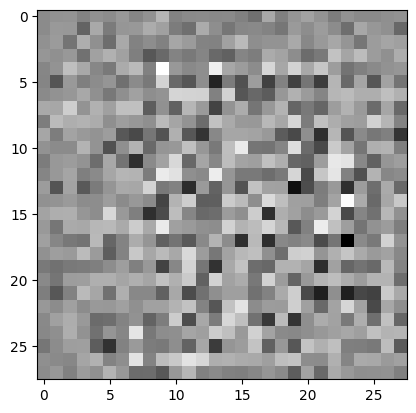

In [24]:
# Feed noise into generator and check output:

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray') ;

## Discriminator
The discriminator is a CNN-based image classifier.

In [27]:
def make_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(
                            64,
                            (5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=[28, 28, 1]
                            )
              )

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(
                            128,
                            (5, 5),
                            strides=(2, 2),
                            padding='same'
                            )
              )

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [28]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00536854]], shape=(1, 1), dtype=float32)


The *from_logits* parameter in BinaryCrossentropy determines whether the input *y_pred* is a probability distribution or a logit value. A logit value is the output of a linear regression model, which is not normalized and can take any value between negative and positive infinity.   <br>
[Here](https://saturncloud.io/blog/tensorflow-understanding-the-fromlogits-parameter-in-sparse-categorical-crossentropy/) is a tensorflow blog on *from_logits* parameter

In [30]:
# This method returns a helper function to compute cross entropy loss
# Our NN output can be upto infinity

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [32]:
def discriminator_loss(real_output, fake_output):
    # Some genuine images were also predicted as fake:
    # tf.ones_like(real_output) is like np.ones_like(real_output)
    # That is, as many ones as the number of real_output

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Some fake images were also predicted as genuine:
    # tf.zeros_like(fake_output) is like np.zeros_like(fake_output)
    # That is, as many ones as the number of fake_output

    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # So total loss is:
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

The discriminator and the generator optimizers are different since you will train two networks separately.

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoint

This demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted. Why save optimizer? See StackOverflow [here](https://stackoverflow.com/a/49504376/3282777)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                 )